# News Category Prediction Problem

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
!pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

In [3]:
train_data = pd.read_excel('Data_Train.xlsx')
test_data = pd.read_excel('Data_Test.xlsx')


In [4]:
train_data.head(10)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3
5,BEIJING: Chinese tech giant Huawei has announc...,1
6,Mumbai: India Inc's external commercial borrow...,3
7,"On Wednesday, Federal Reserve Chairman Jerome ...",3
8,What more can you give to the audience? I have...,2
9,"com, Arbaaz Khan spoke about getting back to D...",2


In [5]:
print("Number of data points in train data", train_data.shape)
print('-'*50)
print("The attributes of data :", train_data.columns.values)


Number of data points in train data (7628, 2)
--------------------------------------------------
The attributes of data : ['STORY' 'SECTION']


# Text Preprocessing

In [6]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [8]:
len(stopwords)

176

In [9]:
from tqdm import tqdm
preprocessed_train_data = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_train_data.append(sent.lower().strip())


100%|██████████| 7628/7628 [00:02<00:00, 2781.66it/s]


In [10]:
train_data['preprocessed_STORY'] = preprocessed_train_data
train_data.drop(['STORY'], axis=1, inplace=True)

In [11]:
from tqdm import tqdm
preprocessed_test_data = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_test_data.append(sent.lower().strip())

100%|██████████| 2748/2748 [00:01<00:00, 2720.43it/s]


In [12]:
test_data['preprocessed_STORY'] = preprocessed_test_data
test_data.drop(['STORY'], axis=1, inplace=True)

In [13]:
train_data['preprocessed_STORY']

train_data.shape

train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

## Splitting Dataset

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [15]:
train_data[train_data.isnull().any(axis=1)]

,SECTION,preprocessed_STORY


In [16]:
y=train_data['SECTION']
y.shape

(7628,)

In [17]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true'
X_train, test_df, y_train, y_test = train_test_split(train_data, y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train'
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

In [18]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 4881
Number of data points in test data: 1526
Number of data points in cross validation data: 1221


In [19]:
train_class_distribution = train_df['SECTION'].value_counts()
type(train_class_distribution)

pandas.core.series.Series

## Distribution of y_i's in Train, Test and Cross Validation datasets

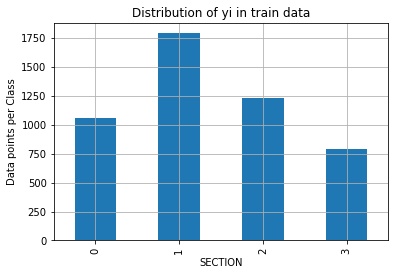

Number of data points in class 2 : 1790 ( 36.673 %)
Number of data points in class 3 : 1235 ( 25.302 %)
Number of data points in class 1 : 1062 ( 21.758 %)
Number of data points in class 4 : 794 ( 16.267 %)
--------------------------------------------------------------------------------


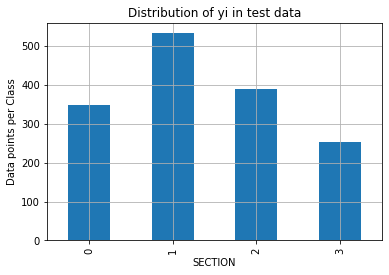

Number of data points in class 2 : 533 ( 34.928 %)
Number of data points in class 3 : 391 ( 25.623 %)
Number of data points in class 1 : 348 ( 22.805 %)
Number of data points in class 4 : 254 ( 16.645 %)
--------------------------------------------------------------------------------


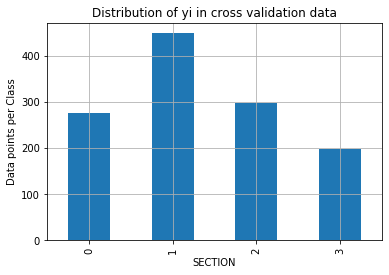

Number of data points in class 2 : 449 ( 36.773 %)
Number of data points in class 3 : 298 ( 24.406 %)
Number of data points in class 1 : 276 ( 22.604 %)
Number of data points in class 4 : 198 ( 16.216 %)


In [20]:
train_class_distribution = train_df['SECTION'].value_counts().sort_index()
test_class_distribution = test_df['SECTION'].value_counts().sort_index()
cv_class_distribution = cv_df['SECTION'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## Univariate Analysis on Text Feature

In [21]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [22]:
# OHE AND RESPONSE CODING
#----------------------------------
import collections
from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['preprocessed_STORY'].split():
            dictionary[word] +=1
    return dictionary


In [23]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],4))
    for i in range(0,3):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['preprocessed_STORY'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+40)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['preprocessed_STORY'].split()))
            row_index += 1
    return text_feature_responseCoding


In [24]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=2)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['preprocessed_STORY'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 15455


In [25]:
dict_list = []
# dict_list =[] contains 4 dictoinaries each corresponds to a class
for i in range(0,3):
    cls_text = train_df[train_df['SECTION']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,3):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+40))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [26]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [27]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [28]:
from sklearn.preprocessing import Normalizer
#to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['preprocessed_STORY'])
#to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['preprocessed_STORY'])
#to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [29]:
# we use the same vectorizer that was trained on train data
data_test_text__onehotCoding = text_vectorizer.transform(test_data['preprocessed_STORY'])
# to normalize every feature
data_test__onehotCoding = normalize(data_test_text__onehotCoding, axis=0)

In [30]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [31]:
#WORD2VEC MODEL:
i=0
list_of_sentance=[]
for sentance in train_data['preprocessed_STORY'].values:
    list_of_sentance.append(sentance.split())

In [32]:
w2v_model=Word2Vec(list_of_sentance,size=200,min_count=2)
w2v_words = list(w2v_model.wv.vocab)

In [33]:
#train_df list_of_sentance_2
i=0
list_of_sentance_2=[]
for sentance in train_df['preprocessed_STORY'].values:
    list_of_sentance_2.append(sentance.split())
    
#cv_df list_of_sentance_3
i=0
list_of_sentance_3=[]
for sentance in cv_df['preprocessed_STORY'].values:
    list_of_sentance_3.append(sentance.split())
    
    
#test_df list_of_sentance_4
i=0
list_of_sentance_4=[]
for sentance in test_df['preprocessed_STORY'].values:
    list_of_sentance_4.append(sentance.split())
        
#test_data list_of_sentance_5
i=0
list_of_sentance_5=[]
for sentance in test_data['preprocessed_STORY'].values:
    list_of_sentance_5.append(sentance.split())
    

In [34]:
# Avg Word2Vec for train_df

sent_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_2): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 200,
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_2.append(sent_vec)
print(len(sent_vectors_2))
print(len(sent_vectors_2[0]))

100%|██████████| 4881/4881 [00:29<00:00, 167.82it/s]

4881
200


In [35]:
# Avg Word2Vec for cv_df

sent_vectors_3 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_3): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 200.
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_3.append(sent_vec)
print(len(sent_vectors_3))
print(len(sent_vectors_3[0]))

100%|██████████| 1221/1221 [00:06<00:00, 175.18it/s]

1221
200


In [36]:
# Avg Word2Vec for test_df

sent_vectors_4 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_4): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 200.
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_4.append(sent_vec)
print(len(sent_vectors_4))
print(len(sent_vectors_4[0]))

100%|██████████| 1526/1526 [00:09<00:00, 159.77it/s]

1526
200


In [37]:
# Avg Word2Vec for test_data

sent_vectors_5 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_5): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 200.
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_5.append(sent_vec)
print(len(sent_vectors_5))
print(len(sent_vectors_5[0]))

100%|██████████| 2748/2748 [00:17<00:00, 161.48it/s]

2748
200


In [38]:
train_text_feature_vectorization=np.array(sent_vectors_2)
cv_text_feature_vectorization=np.array(sent_vectors_3)
test_text_feature_vectorization=np.array(sent_vectors_4)
test_data_feature_vectorization=np.array(sent_vectors_5)

For values of alpha =  1e-07 The log loss is: 0.23626220227620282
For values of alpha =  1e-06 The log loss is: 0.2251387756698837
For values of alpha =  1e-05 The log loss is: 0.22508208205395414
For values of alpha =  0.0001 The log loss is: 0.2621617360166513
For values of alpha =  0.001 The log loss is: 0.3087027175158702
For values of alpha =  0.01 The log loss is: 0.3612853395110608
For values of alpha =  0.1 The log loss is: 0.4346337197108817
For values of alpha =  1 The log loss is: 0.5089259330012161


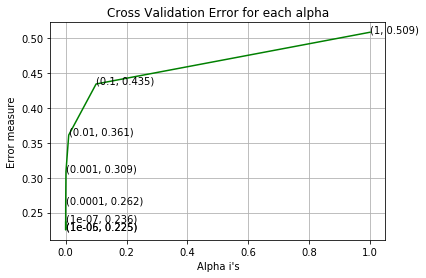

For values of best alpha =  1e-05 The train log loss is: 0.22641401016111293
For values of best alpha =  1e-05 The cross validation log loss is: 0.22508208205395414
For values of best alpha =  1e-05 The test log loss is: 0.2482732033894861


In [39]:
# Train a Logistic regression+Calibration model using text features which are vectorized

alpha = [10 ** x for x in range(-7, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_vectorization, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_vectorization, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_vectorization)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_vectorization, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_vectorization, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Text feature stable across all the data sets (Test, Train, Cross validation)

In [40]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['preprocessed_STORY'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.451 % of word of test data appeared in train data
98.816 % of word of Cross Validation appeared in train data


# Machine Learning Models

In [41]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [42]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [43]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Prepare final  dataset

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_text_feature_vectorization = scaler.fit_transform(train_text_feature_vectorization)

test_text_feature_vectorization = scaler.fit_transform(test_text_feature_vectorization)

cv_text_feature_vectorization = scaler.fit_transform(cv_text_feature_vectorization)

test_data_feature_vectorization= scaler.fit_transform(test_data_feature_vectorization)

In [45]:
print(train_text_feature_vectorization)

[[0.55291902 0.27551614 0.26626189 ... 0.41315865 0.84087587 0.56009975]
 [0.71903458 0.21128813 0.23675457 ... 0.51433999 0.8154708  0.69354791]
 [0.81984585 0.67749061 0.26971613 ... 0.61697351 0.59032362 0.62613156]
 ...
 [0.54875287 0.37734428 0.28215049 ... 0.50529561 0.78697399 0.48871864]
 [0.67246382 0.44073863 0.37035636 ... 0.60582375 0.49795586 0.68412718]
 [0.87173871 0.67110512 0.36151435 ... 0.40747335 0.63261832 0.81653365]]


In [46]:
train_x_vectorization = ((train_text_feature_vectorization))
train_y = np.array(list(train_df['SECTION']))

test_x_vectorization = ((test_text_feature_vectorization))
test_y = np.array(list(test_df['SECTION']))

cv_x_vectorization = ((cv_text_feature_vectorization))
cv_y = np.array(list(cv_df['SECTION']))

In [47]:
print(train_x_vectorization.shape)

(4881, 200)


In [48]:
train_x_onehotCoding = ((train_text_feature_onehotCoding))
train_y = np.array(list(train_df['SECTION']))

test_x_onehotCoding = ((test_text_feature_onehotCoding))
test_y = np.array(list(test_df['SECTION']))

cv_x_onehotCoding = ((cv_text_feature_onehotCoding))
cv_y = np.array(list(cv_df['SECTION']))

In [49]:
train_x_responseCoding = ((train_text_feature_responseCoding))
test_x_responseCoding = ((test_text_feature_responseCoding))
cv_x_responseCoding = ((cv_text_feature_responseCoding))


In [50]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [51]:
train_data["SECTION"].value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

In [52]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [53]:
print("Vectorized features :")
print("(number of data points * number of features) in train data = ", train_x_vectorization.shape)
print("(number of data points * number of features) in test data = ", test_x_vectorization.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_vectorization.shape)

Vectorized features :
(number of data points * number of features) in train data =  (4881, 200)
(number of data points * number of features) in test data =  (1526, 200)
(number of data points * number of features) in cross validation data = (1221, 200)


In [54]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)


 Response encoding features :
(number of data points * number of features) in train data =  (4881, 4)
(number of data points * number of features) in test data =  (1526, 4)
(number of data points * number of features) in cross validation data = (1221, 4)


## Base Line Model

## Naive Bayes

## Hyper parameter tuning

for alpha = 1e-06
Log Loss : 0.4574567451524552
for alpha = 1e-05
Log Loss : 0.45745674463873326
for alpha = 0.0001
Log Loss : 0.45745673950156174
for alpha = 0.001
Log Loss : 0.45745668813049245
for alpha = 0.1
Log Loss : 0.45745104456761715
for alpha = 1
Log Loss : 0.45740038854593174
for alpha = 10
Log Loss : 0.4569488755536253
for alpha = 100
Log Loss : 0.45392506691577134
for alpha = 1000
Log Loss : 0.46279259812209855


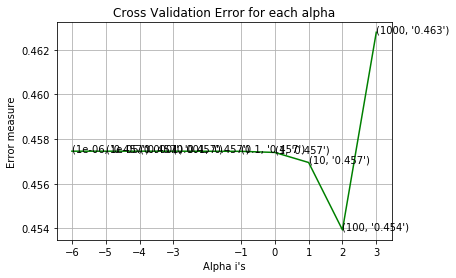

For values of best alpha =  100 The train log loss is: 0.4592299591030977
For values of best alpha =  100 The cross validation log loss is: 0.45392506691577134
For values of best alpha =  100 The test log loss is: 0.4544299634409059


In [55]:
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_vectorization, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vectorization, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)


predict_y = sig_clf.predict_proba(train_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Testing the model with best hyper paramters

Log Loss : 0.45392506691577134
Number of missclassified point : 0.15724815724815724
-------------------- Confusion matrix --------------------


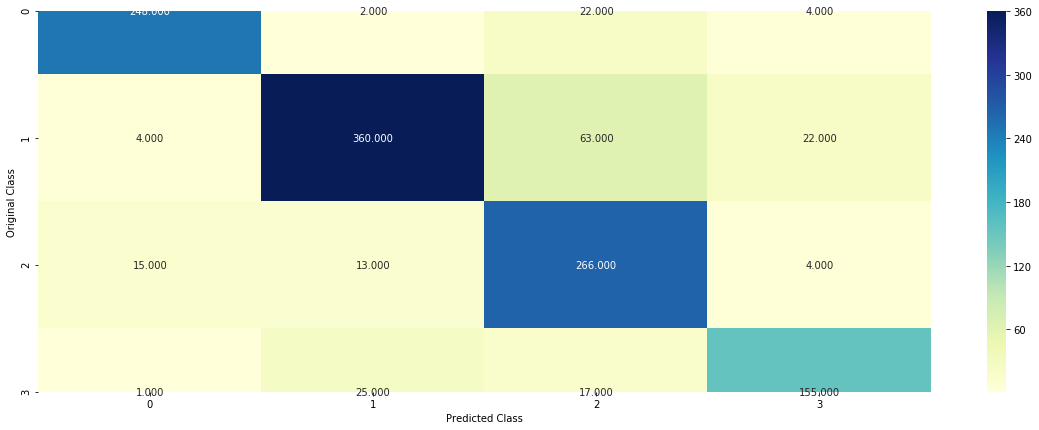

-------------------- Precision matrix (Columm Sum=1) --------------------


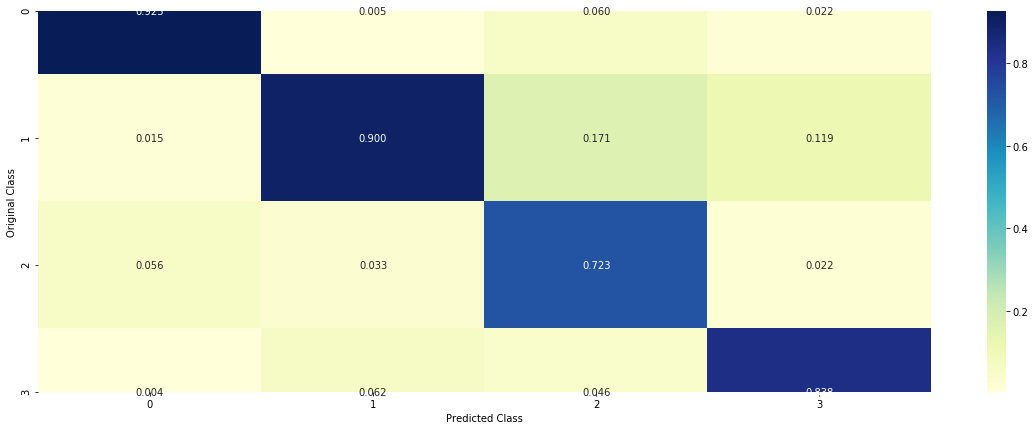

-------------------- Recall matrix (Row sum=1) --------------------


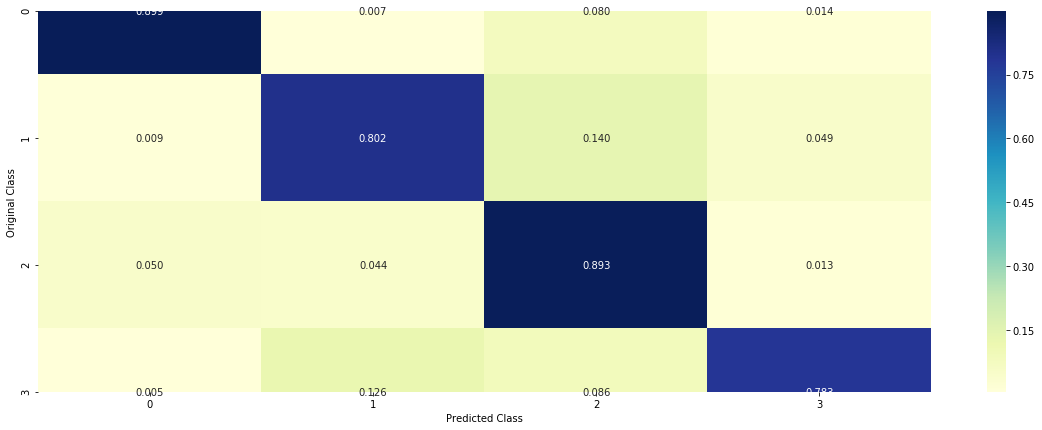

Predicted Class : 1
Predicted Class Probabilities: [[0.0247 0.8973 0.002  0.0761]]
Actual Class : 1


In [56]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_vectorization)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_vectorization))

"""### Correctly classified point"""

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_vectorization[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vectorization[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])


## K Nearest Neighbour Classification

## Hyper parameter tuning

for alpha = 5
Log Loss : 0.3216317900879781
for alpha = 11
Log Loss : 0.3045005333940337
for alpha = 15
Log Loss : 0.3052469270426288
for alpha = 21
Log Loss : 0.30846236797358506
for alpha = 31
Log Loss : 0.31412914006381343
for alpha = 41
Log Loss : 0.3182108552136648
for alpha = 51
Log Loss : 0.32084081405879683
for alpha = 99
Log Loss : 0.3244272033034001


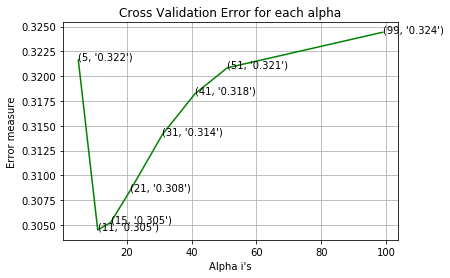

For values of best alpha =  11 The train log loss is: 0.21987218335198747
For values of best alpha =  11 The cross validation log loss is: 0.3045005333940337
For values of best alpha =  11 The test log loss is: 0.2765227725748025


In [57]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Testing the model with best hyper paramters

Log loss : 0.3045005333940337
Number of mis-classified points : 0.09746109746109746
-------------------- Confusion matrix --------------------


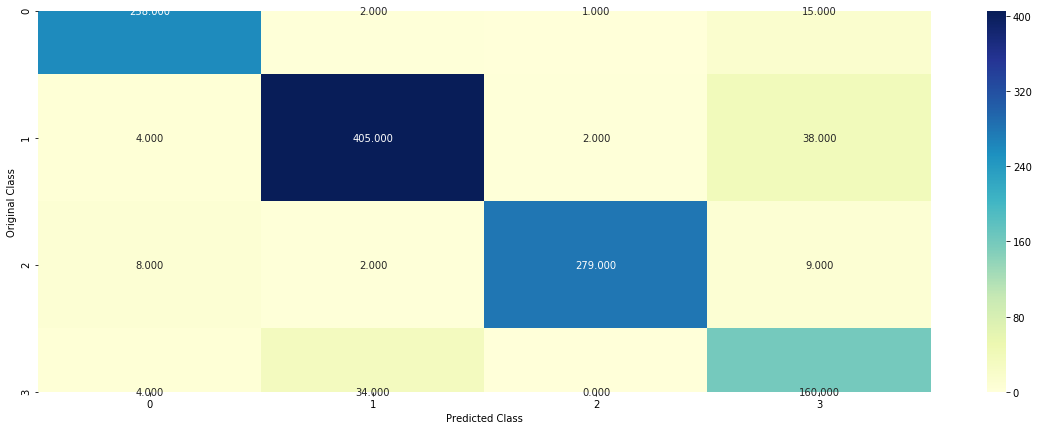

-------------------- Precision matrix (Columm Sum=1) --------------------


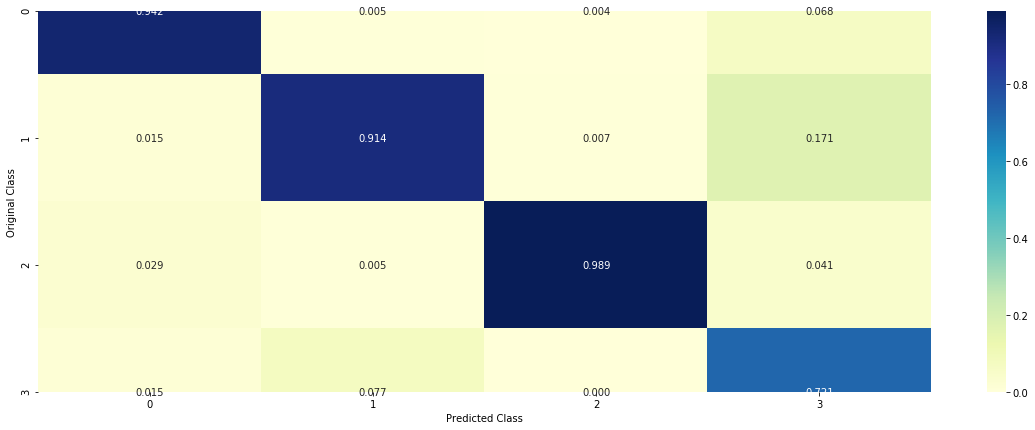

-------------------- Recall matrix (Row sum=1) --------------------


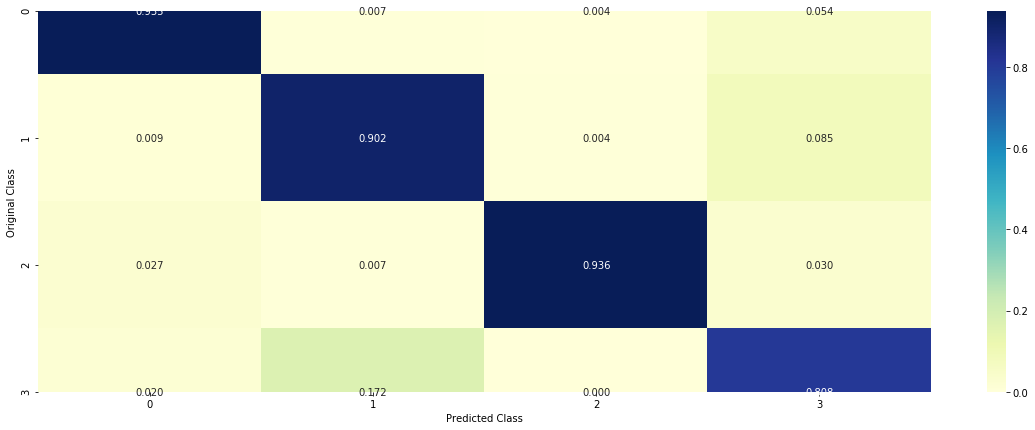

In [58]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [59]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 1
The  11  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 11})


In [60]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 0
Actual Class : 0
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [0 0 0 0 0 0 0 0 0 0 0]
Fequency of nearest points : Counter({0: 11})


## Logistic Regression(With Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.22499255028450835
for alpha = 1e-05
Log Loss : 0.22464702384789909
for alpha = 0.0001
Log Loss : 0.2481434208609496
for alpha = 0.001
Log Loss : 0.30898229181865106
for alpha = 0.01
Log Loss : 0.35767084368972135
for alpha = 0.1
Log Loss : 0.4243280688915506


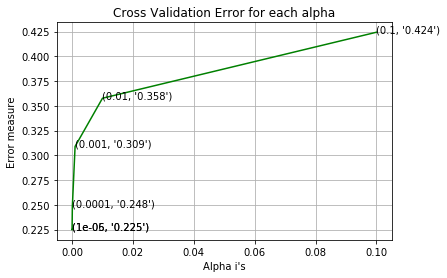

For values of best alpha =  1e-05 The train log loss is: 0.23173795868145686
For values of best alpha =  1e-05 The cross validation log loss is: 0.22464702384789909
For values of best alpha =  1e-05 The test log loss is: 0.311575188813016


In [61]:
alpha = [10 ** x for x in range(-6, 0)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vectorization, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vectorization, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)

predict_y = sig_clf.predict_proba(train_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyper paramters

Log loss : 0.22464702384789909
Number of mis-classified points : 0.07616707616707617
-------------------- Confusion matrix --------------------


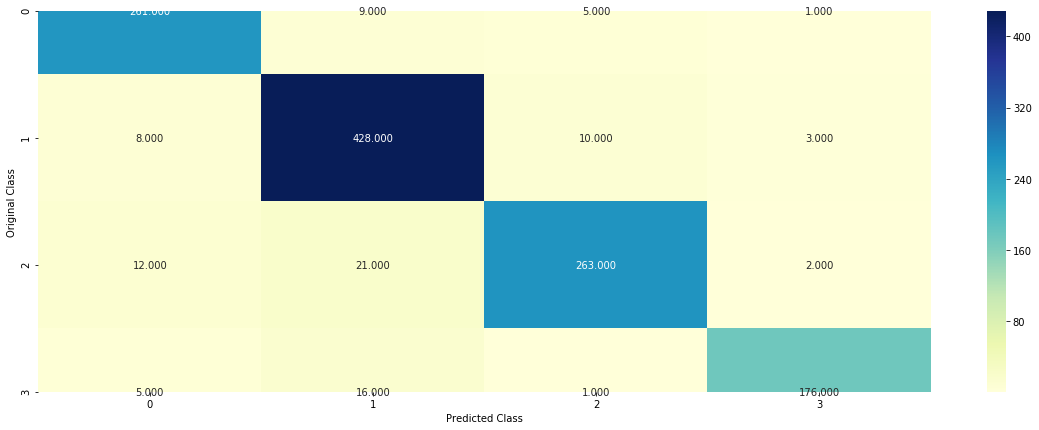

-------------------- Precision matrix (Columm Sum=1) --------------------


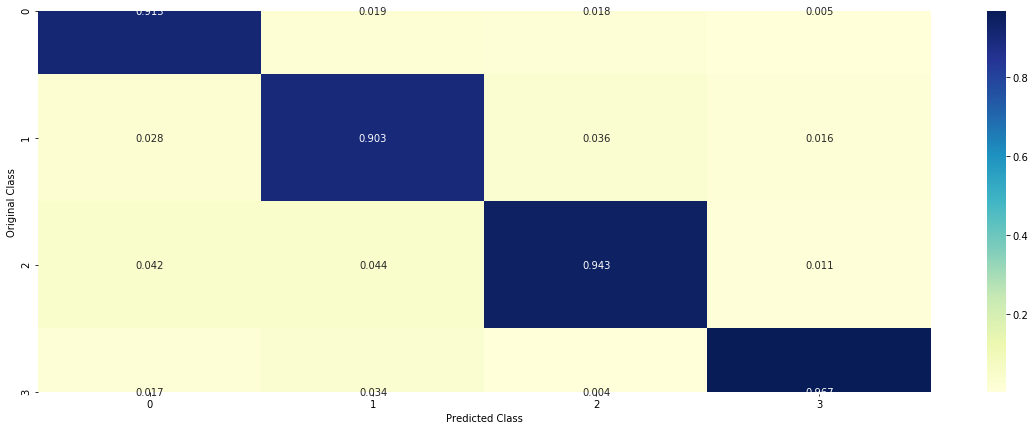

-------------------- Recall matrix (Row sum=1) --------------------


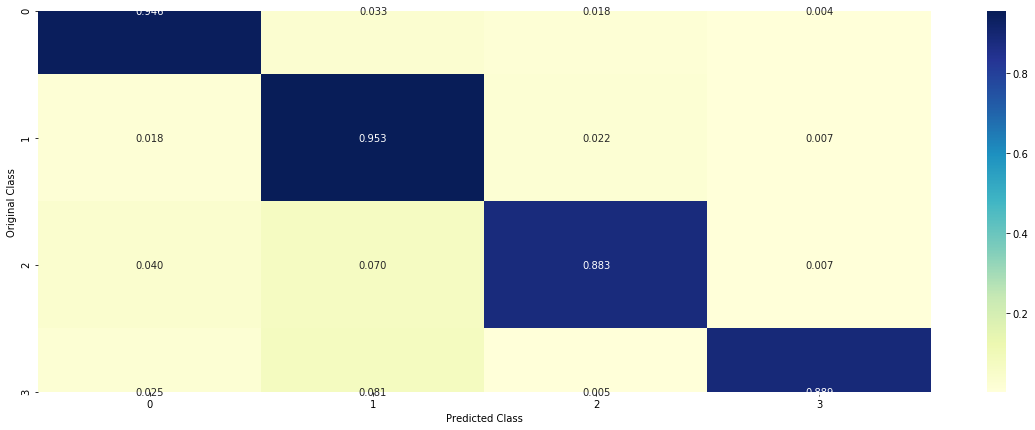

In [62]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vectorization, train_y, cv_x_vectorization, cv_y, clf)


In [63]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vectorization,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vectorization[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vectorization[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])


Predicted Class : 1
Predicted Class Probabilities: [[0.000e+00 9.992e-01 0.000e+00 8.000e-04]]
Actual Class : 1


## Logistic Regression(Without Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.2272197944137101
for alpha = 1e-05
Log Loss : 0.23456660222937262
for alpha = 0.0001
Log Loss : 0.2474504874762368
for alpha = 0.001
Log Loss : 0.30917979454254346
for alpha = 0.01
Log Loss : 0.3602641735577691
for alpha = 0.1
Log Loss : 0.4263162396217916
for alpha = 1
Log Loss : 0.5028300801809631


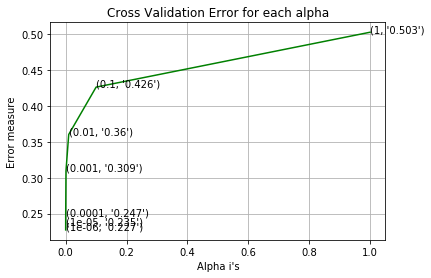

For values of best alpha =  1e-06 The train log loss is: 0.2380683046857675
For values of best alpha =  1e-06 The cross validation log loss is: 0.2272197944137101
For values of best alpha =  1e-06 The test log loss is: 0.3100071285195588


In [64]:

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vectorization, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vectorization, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)

predict_y = sig_clf.predict_proba(train_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log loss : 0.2272197944137101
Number of mis-classified points : 0.07780507780507781
-------------------- Confusion matrix --------------------


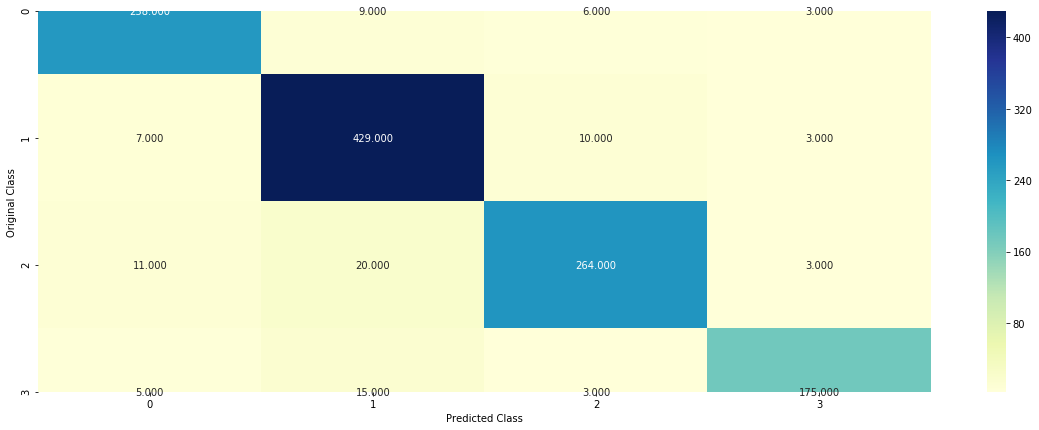

-------------------- Precision matrix (Columm Sum=1) --------------------


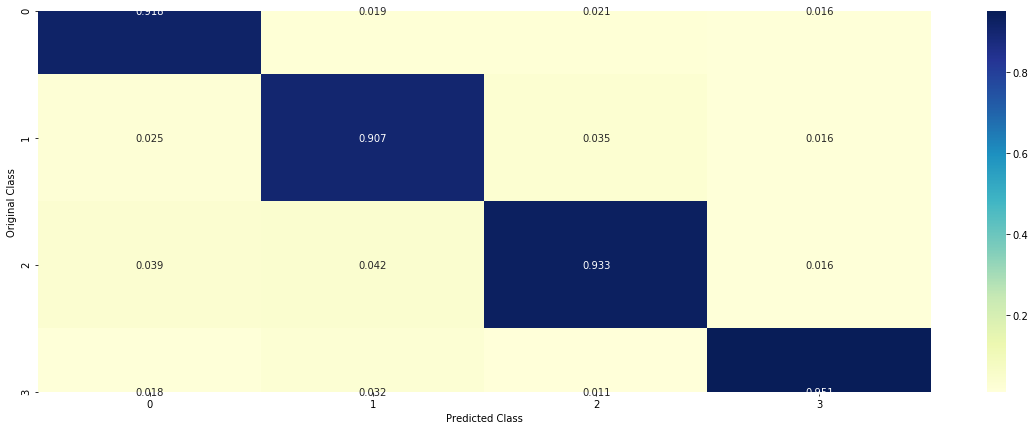

-------------------- Recall matrix (Row sum=1) --------------------


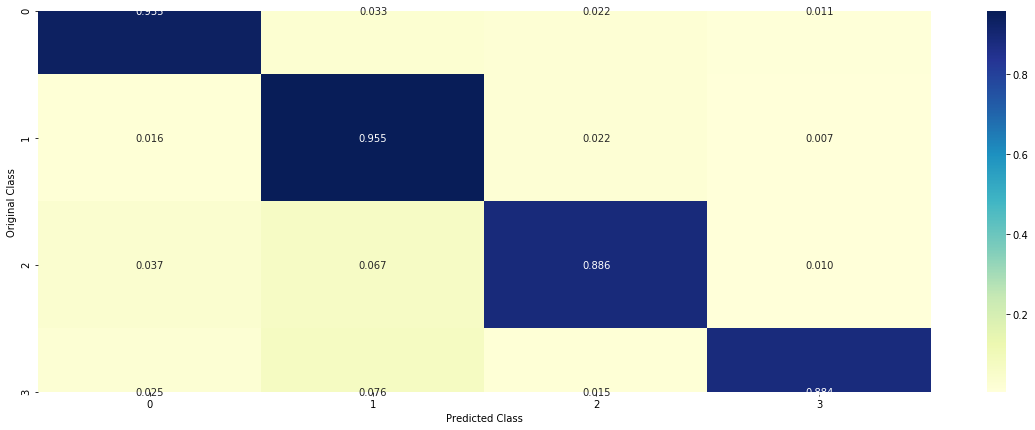

In [65]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vectorization, train_y, cv_x_vectorization, cv_y, clf)

In [66]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vectorization,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vectorization[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vectorization[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.000e+00 9.996e-01 0.000e+00 4.000e-04]]
Actual Class : 1


## Linear Support Vector Machines

### Hyper paramter tuning

for C = 1e-06
Log Loss : 0.22371179346506456
for C = 1e-05
Log Loss : 0.2295139884612053
for C = 0.0001
Log Loss : 0.24678253669549763
for C = 0.001
Log Loss : 0.28992502923139535
for C = 0.01
Log Loss : 0.3343327959611839


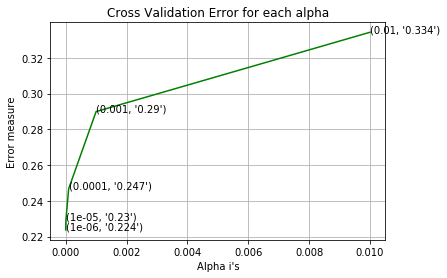

For values of best alpha =  1e-06 The train log loss is: 0.237903934999994
For values of best alpha =  1e-06 The cross validation log loss is: 0.22371179346506456
For values of best alpha =  1e-06 The test log loss is: 0.3009854285684802


In [67]:
alpha = [10 ** x for x in range(-6,-1)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_vectorization, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vectorization, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)

predict_y = sig_clf.predict_proba(train_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vectorization)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log loss : 0.22371179346506456
Number of mis-classified points : 0.06797706797706797
-------------------- Confusion matrix --------------------


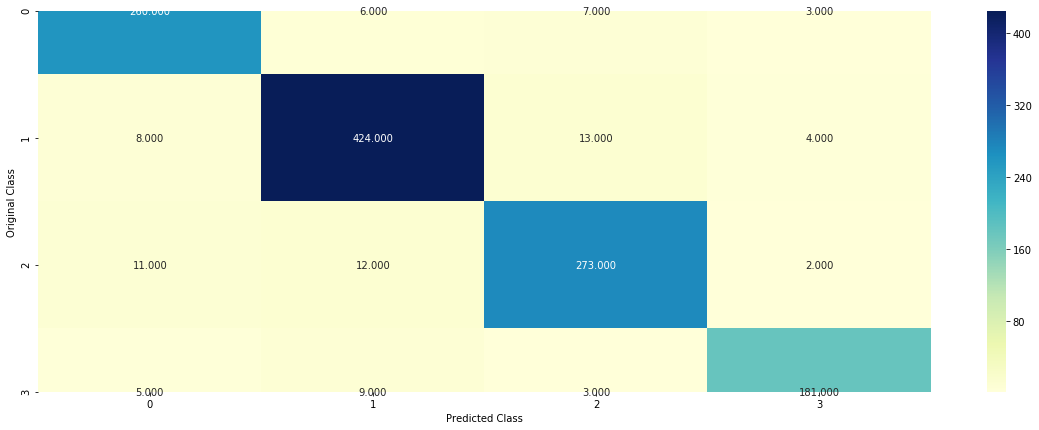

-------------------- Precision matrix (Columm Sum=1) --------------------


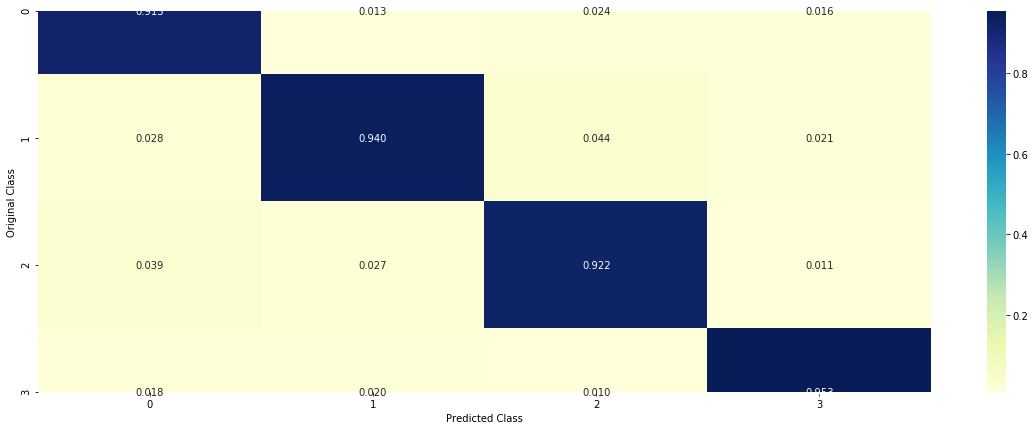

-------------------- Recall matrix (Row sum=1) --------------------


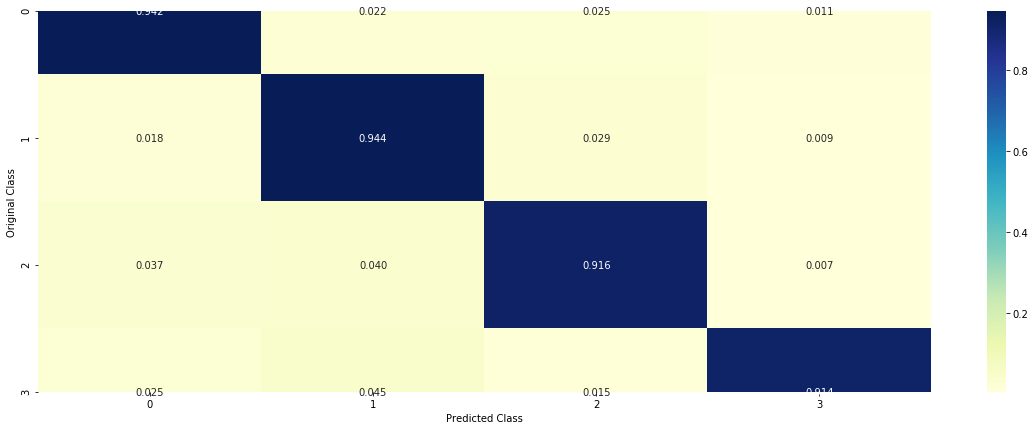

In [70]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_vectorization, train_y,cv_x_vectorization,cv_y, clf)

In [71]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_vectorization,train_y)
test_point_index = 1
# test_point_index = 100

predicted_cls = sig_clf.predict(test_x_vectorization[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vectorization[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.000e+00 9.997e-01 0.000e+00 3.000e-04]]
Actual Class : 1


## Random Forest Classifier(With Avg Word2Vec)

### Hyper paramter tuning

In [72]:
alpha = [500,1000,2000]
max_depth = [5,7,10,12,15]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_vectorization, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_vectorization, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_vectorization)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)

predict_y = sig_clf.predict_proba(train_x_vectorization)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vectorization)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vectorization)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 500 and max depth =  5
Log Loss : 0.30169621964057625
for n_estimators = 500 and max depth =  7
Log Loss : 0.28961659378619503
for n_estimators = 500 and max depth =  10
Log Loss : 0.2864881484502784
for n_estimators = 500 and max depth =  12
Log Loss : 0.28729395195307017
for n_estimators = 500 and max depth =  15
Log Loss : 0.2917928543656086
for n_estimators = 1000 and max depth =  5
Log Loss : 0.30105537599634397
for n_estimators = 1000 and max depth =  7
Log Loss : 0.2891370143127148
for n_estimators = 1000 and max depth =  10
Log Loss : 0.28654543759192125
for n_estimators = 1000 and max depth =  12
Log Loss : 0.2875256630504763
for n_estimators = 1000 and max depth =  15
Log Loss : 0.2908875135041687
for n_estimators = 2000 and max depth =  5
Log Loss : 0.3008166816953716
for n_estimators = 2000 and max depth =  7
Log Loss : 0.2880088253700707
for n_estimators = 2000 and max depth =  10
Log Loss : 0.28611287318318857
for n_estimators = 2000 and max depth =  12

### Testing model with best hyper parameters (With Avg Word2Vec)

Log loss : 0.28611287318318857
Number of mis-classified points : 0.09582309582309582
-------------------- Confusion matrix --------------------


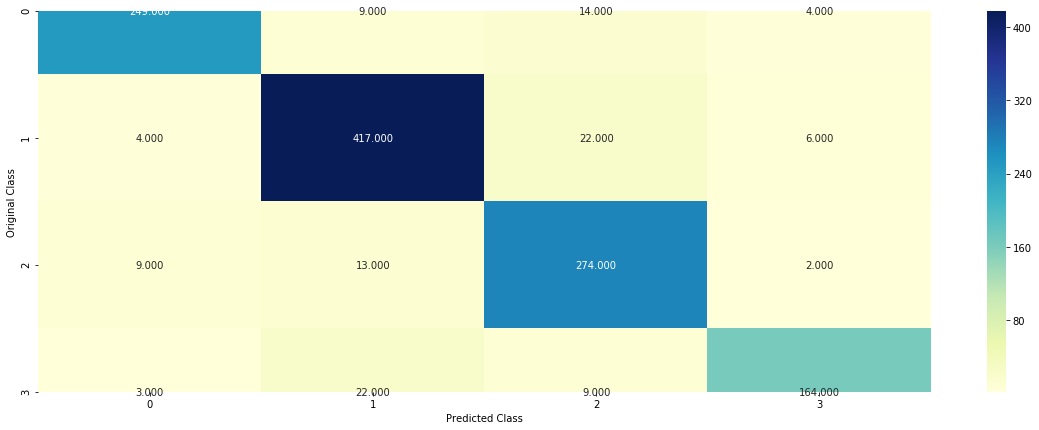

-------------------- Precision matrix (Columm Sum=1) --------------------


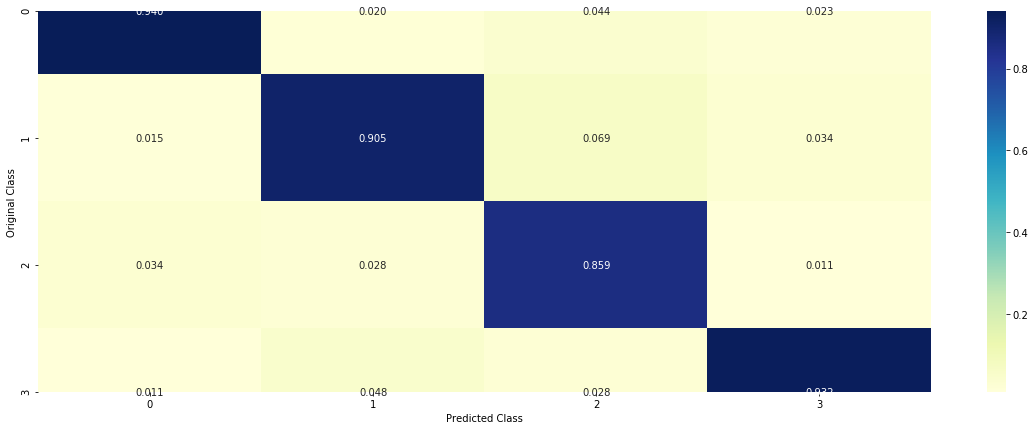

-------------------- Recall matrix (Row sum=1) --------------------


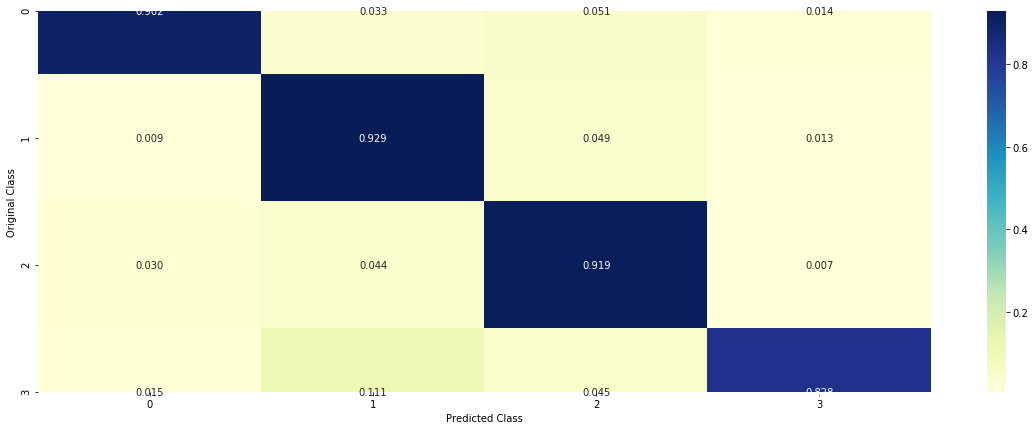

In [73]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_vectorization, train_y,cv_x_vectorization,cv_y, clf)


In [74]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_vectorization, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vectorization, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_x_vectorization[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vectorization[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.0131 0.9639 0.014  0.009 ]]
Actual Class : 1


## Random Forest Classifier(With Response Coding)

In [75]:
alpha = [100,200,500,1000,1500]
max_depth = [5,7,10,15]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
        
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/5)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/5)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/5)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 100 and max depth =  5
Log Loss : 0.3181280008931829
for n_estimators = 100 and max depth =  7
Log Loss : 0.31002947312229306
for n_estimators = 100 and max depth =  10
Log Loss : 0.315582087887641
for n_estimators = 100 and max depth =  15
Log Loss : 0.3115721833192852
for n_estimators = 200 and max depth =  5
Log Loss : 0.31868705083252913
for n_estimators = 200 and max depth =  7
Log Loss : 0.3111311981057594
for n_estimators = 200 and max depth =  10
Log Loss : 0.3144577368013661
for n_estimators = 200 and max depth =  15
Log Loss : 0.3121653352872879
for n_estimators = 500 and max depth =  5
Log Loss : 0.31887961121627356
for n_estimators = 500 and max depth =  7
Log Loss : 0.31217236259706593
for n_estimators = 500 and max depth =  10
Log Loss : 0.3140561477231654
for n_estimators = 500 and max depth =  15
Log Loss : 0.31338121208145253
for n_estimators = 1000 and max depth =  5
Log Loss : 0.31925606839425874
for n_estimators = 1000 and max depth =  7
Log Loss 

Log loss : 0.31002947312229306
Number of mis-classified points : 0.09582309582309582
-------------------- Confusion matrix --------------------


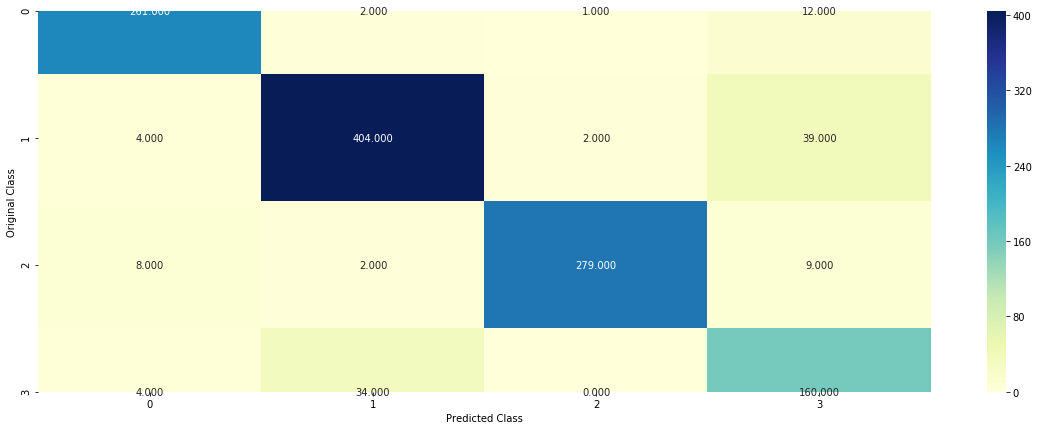

-------------------- Precision matrix (Columm Sum=1) --------------------


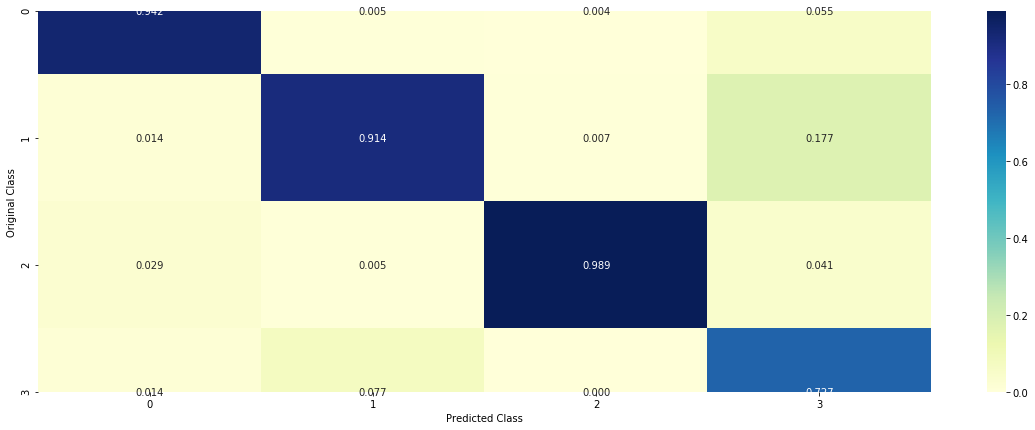

-------------------- Recall matrix (Row sum=1) --------------------


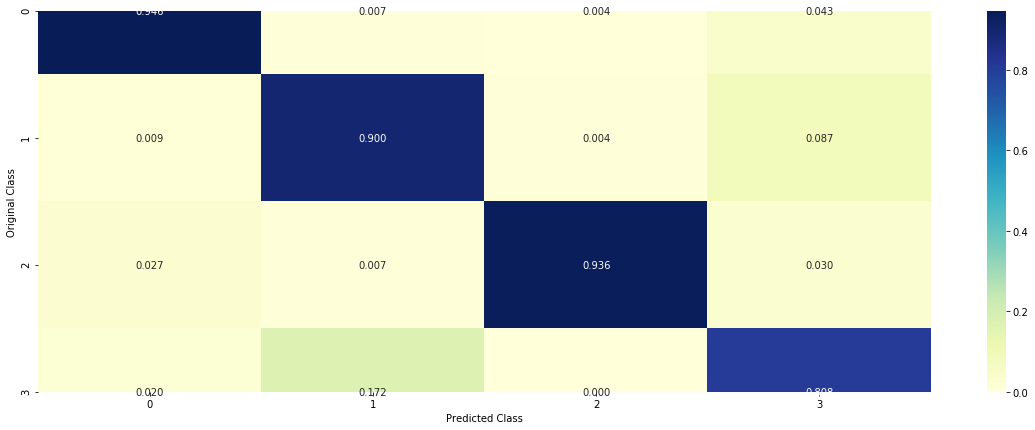

In [76]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%5)], n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [77]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.0097 0.9631 0.0092 0.018 ]]
Actual Class : 1


## Stack the models

### testing with hyper parameter tuning

In [78]:
clf1 = SGDClassifier(alpha=0.00000007 , penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_vectorization, train_y)
sig_clf1 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_vectorization, train_y)

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_vectorization, train_y)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_vectorization, train_y)


clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_vectorization, train_y)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_vectorization, train_y)


clf4 = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=7, random_state=42, n_jobs=-1)
clf4.fit(train_x_responseCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf4.fit(train_x_responseCoding, train_y)


clf5 = KNeighborsClassifier(n_neighbors=11)
clf5.fit(train_x_responseCoding, train_y)
sig_clf5 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf5.fit(train_x_responseCoding, train_y)



print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_vectorization))))

print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_vectorization))))

print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_vectorization))))

print("Random forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_responseCoding))))

print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_responseCoding))))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10,20,50] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_vectorization, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_vectorization))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_vectorization))
    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 0.29
Support vector machines : Log Loss: 0.29
Naive Bayes : Log Loss: 0.29
Random forest : Log Loss: 0.31
K Nearest Neighbour : Log Loss: 0.31
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.236
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.726
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.368
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.319
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.323
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.324
Stacking Classifer : for the value of alpha: 20.000000 Log Loss: 0.324
Stacking Classifer : for the value of alpha: 50.000000 Log Loss: 0.324


### testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.18945745205064524
Log loss (CV) on the stacking classifier : 0.3227608398589381
Log loss (test) on the stacking classifier : 0.3258556582001608
Number of missclassified point : 0.0910878112712975
-------------------- Confusion matrix --------------------


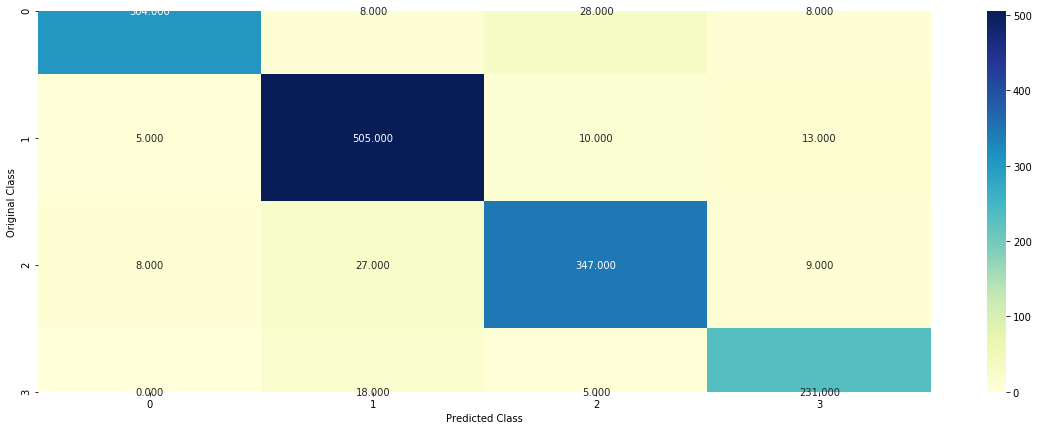

-------------------- Precision matrix (Columm Sum=1) --------------------


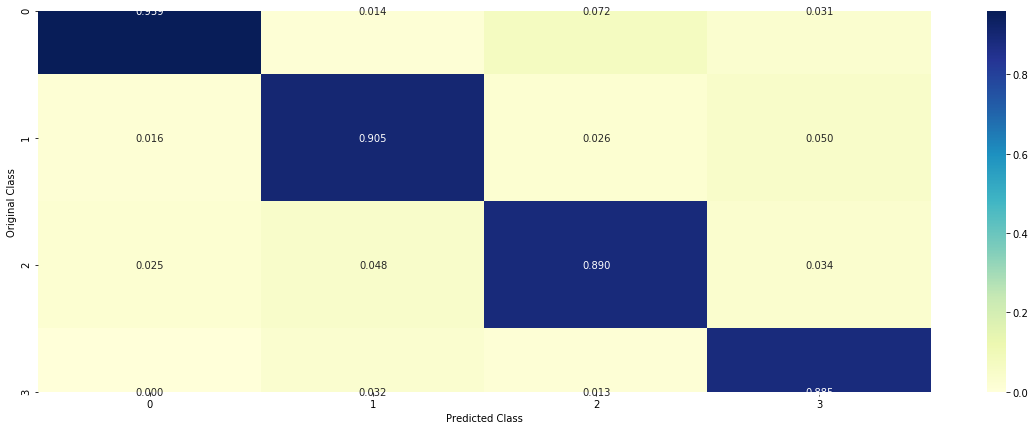

-------------------- Recall matrix (Row sum=1) --------------------


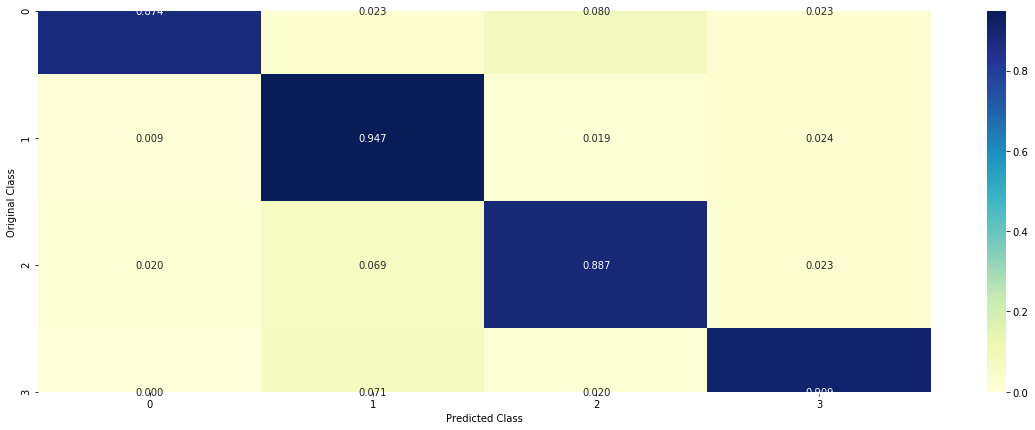

In [79]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_vectorization, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_vectorization))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_vectorization))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_vectorization))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_vectorization)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_vectorization))

In [80]:
predictions = sclf.predict(test_data_feature_vectorization)
print(predictions)

[1 2 1 ... 1 1 1]


In [81]:
new_series = pd.Series(predictions)
new_series.value_counts()

1    1265
2     841
0     364
3     278
dtype: int64

In [82]:
train_data.head(10)

,SECTION,preprocessed_STORY
0,3,but painful huge reversal fee income unheard a...
1,0,how formidable opposition alliance among congr...
2,3,most asian currencies trading lower today sout...
3,1,if want answer question click answer after cli...
4,3,in global markets gold prices edged today disa...
5,1,beijing chinese tech giant huawei announced pl...
6,3,mumbai india inc external commercial borrowing...
7,3,on wednesday federal reserve chairman jerome p...
8,2,what give audience i already done yeh hai aash...
9,2,com arbaaz khan spoke getting back dabangg sal...


In [83]:
predictions = pd.DataFrame(new_series, columns=['SECTION'])
predictions.to_excel("News_category_submission.xlsx", index=False)

Log loss (train) on the VotingClassifier : 0.18159133637741828
Log loss (CV) on the VotingClassifier : 0.29059292509409784
Log loss (test) on the VotingClassifier : 0.3063852902043613
Number of missclassified point : 0.0891218872870249
-------------------- Confusion matrix --------------------


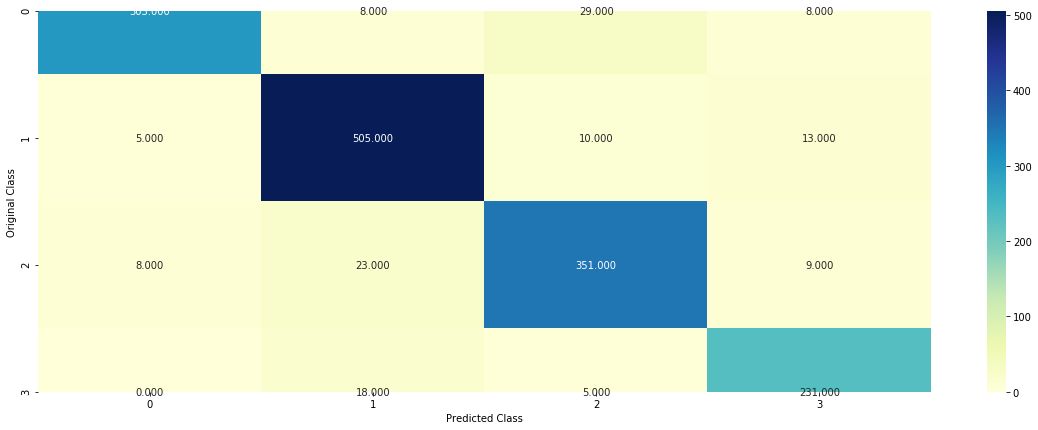

-------------------- Precision matrix (Columm Sum=1) --------------------


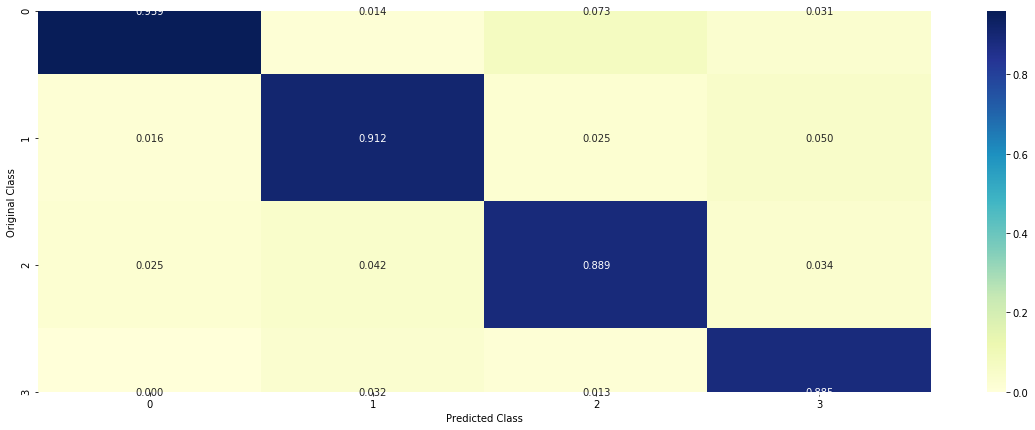

-------------------- Recall matrix (Row sum=1) --------------------


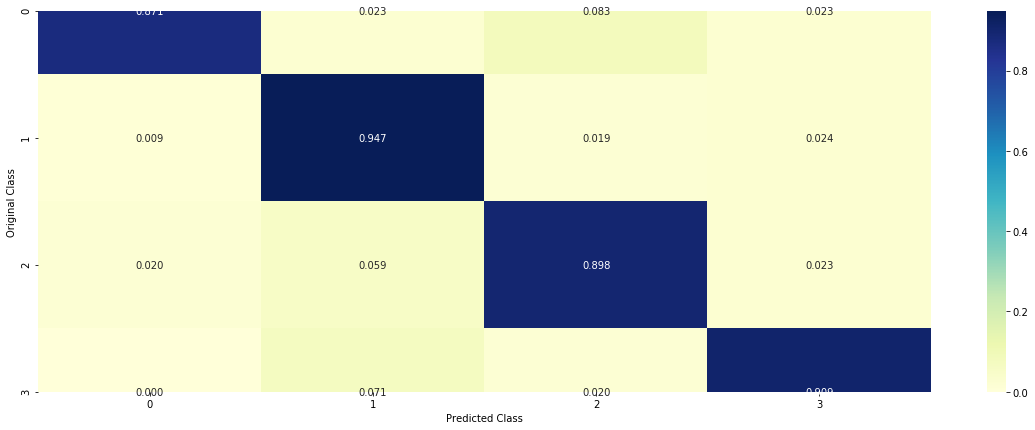

In [84]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3),('rf', sig_clf4),('knn', sig_clf5)], voting='soft')
vclf.fit(train_x_vectorization, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_vectorization)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_vectorization)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_vectorization)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_vectorization)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_vectorization))